# <center>Humor as a Mirror: The New Yorker Captions as Reflections of Society, Politics, and Stereotypes</center>

<br/><br/>
<center>
    <img src="data/newyorker_caption_contest_virgin/images/545.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

---

# <center>Milestone 2 : Table of content</center>

0. **Imports, initialisations**

1. **Data preprocessing**
   - 1.1. Cleaning and preprocessing of the dataset
   - 1.2. Constructing a Funny-like metric
   - 1.3. Gathering of other datasets
   - 1.4. Executing the DataPreparation.ipynb file
   - 1.5. Tokenisation and lemmatisation of data

2. **Descriptive statistic tasks**
    - 2.1. Basic data exploration: missing data, vote distribution...

3. **Building usefull metrics**
    - 3.1. Similarity metric

4. **Narrative Flow**
   - 4.1. **Axis 1 – What Is Considered Funny**
   - 4.2. **Axis 2 – Professions, Politics, and Power**
   - 4.3. **Axis 3 – Gender Roles**

## 0. Imports, initialisations

In [1]:
import pandas as pd
from pathlib import Path
import sys
import os
import pickle
import json
import ast
from collections import Counter

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# models
from src.models.gender_analysis import GenderAnalysis


%matplotlib inline

In [2]:
from src.utils.general_utils import *

In case an import cannot be imported run this:

In [3]:
import importlib
import src.utils.paths as p
importlib.reload(p)

<module 'src.utils.paths' from '/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42/src/utils/paths.py'>

Getting the project root directory path.

In [4]:
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


### Path system

To be consitent in our **path system**, a **centralized file** has been created in 'src\utils\paths.py' and contains all relative paths of the project.

In [23]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(DATA_PREPARATION_PY_PATH.resolve()) #If works: ...../ADAcore42/src/data/DataPreparation.py

/Users/43rt1k/Documents/EPFL/_MASTER/ADA/ADAcore42/src/data/DataPreparation.py


## 1. Data preprocessing

### 1.1. Cleaning and preprocessing of the dataset

[*The main preprocessing is done by this file*](src/data/DataPreparation.py)

##### Concerning the CSV files for each contests, the steps were :
- **Concatenate all 385 CSV in a list of CSV**\
After having done initial analysis and data verification, we observed 2 contests were there were unconsistency. The contest 525 does not have any image nor CSV associated, and the contest 540 does have an image, but any CSV associated. We removed those contests from the dataset. 
- **Remove redundant columns (index and rank)**\
We could import directly with rank index:
        ```python pd.read_csv(f"../newyorker_caption_contest_virgin/data/{i}.csv", index_col=['rank'])```
        but since not all files have column rank it makes sense to import as it is and later remove the redundant column. 


- **Consistency verification**\
Test if there are any NaN, Since data not contain some values, we are searching the NaN and replacing. 
        ```python data.isnull().values.any():```
        return true if there is any value that is null from data 
        ```python dataA3[i].fillna('CAPTION_NOT_FOUND', inplace = True):```
        For dataframe i fill ALL na values with 'text'.

##### Concerning the JSON file, the steps were :
- **Remove non-used columns**\
Only keeping 'metadata' columns of the json, since it contains the relevant datas.
- **Identifying problems**
1. Verify is contests.json size match the quantity of .CSVs.
2.  Search for missing rows. By comparing the expected index (i + dataA_offset, ti get the starting contest_id value) and the actual index (row["contest_id"]) we can verify if any row is missing. We will deal with their filling a bit later. 
3. Verify if for each row contest_id, images and data have always the same number. 
4. Verify if the order of the datas are the same as indexes (ex: (id: 13) == (contest_id - dataA_offset))\
--> It is okay, since the 525.csv and 540.csv are also missing.

- **Define an absolute indexing system**\
Since we know the starting id dataA_startID, we can substract dataA_startID from all rows and get the "normalised" indexes. 
Also dataA is already normalised exluding missing rows, so we have to normalise without missing rows to be consistent with .csv.
From the previous tests (like id vs contest_id) we know that data is sorted by contest_id and hence by id itself.

    In 'src\utils\general_utils.py' are defined two methods to obtain the value of the index in absolute indexing system ('contest_index2absolute_index') or in contest indexing system ('absolute_index2contest_index').


### 1.2. Construction of a New Funny Metric

To better identify which captions are truly funny, we designed a new *funny metric* that combines both the **proportion of votes** and the **popularity (number of votes)** of each caption.

#### 1.2.1. Weighted funny and unfunny ratios

We first compute the proportion of *funny* and *unfunny* votes relative to the total number of votes for each caption:

$$
\text{funny\_ratio} = \frac{N_{\text{funny}}}{N_{\text{total}}}
$$
$$
\text{unfunny\_ratio} = \frac{N_{\text{unfunny}}}{N_{\text{total}}}
$$

To give more importance to captions that received **more votes** (and are thus statistically more reliable), each ratio is weighted by the logarithm of the number of votes:

$$
\text{weighted\_funny} = \text{funny\_ratio} \times \log(1 + N_{\text{total}})
$$
$$
\text{weighted\_unfunny} = \text{unfunny\_ratio} \times \log(1 + N_{\text{total}})
$$

The logarithmic weighting ensures that captions with many votes are emphasized, while preventing those with extremely high vote counts from dominating the score.

#### 1.2.2. Standardization and combined score

We then normalize both weighted ratios using **z-scores** to make them comparable across captions:

$$
z_{\text{funny}} = \frac{\text{weighted\_funny} - \mu_{\text{funny}}}{\sigma_{\text{funny}}}
$$
$$
z_{\text{unfunny}} = \frac{\text{weighted\_unfunny} - \mu_{\text{unfunny}}}{\sigma_{\text{unfunny}}}
$$

Finally, the two standardized scores are combined into a **single composite score**:

$$
\text{combined\_score} = z_{\text{funny}} - z_{\text{unfunny}}
$$

A higher `combined_score` indicates captions that are **consistently rated funny** and **supported by a sufficient number of votes**.

#### 1.2.3. Ranking

All captions are then ranked according to this score:

$$
\text{rank\_funny} = \text{rank}(-\text{combined\_score})
$$

The highest `combined_score` (most funny) receives rank 1.


### 1.3. Gathering of other datasets

#### 1.3.1. Temporal dataset augmentation :

The following webpage has **dates of some of the contests**. We add it to the **dataC** table as a new column:
"https://nextml.github.io/caption-contest-data/"

The next steps are followed, all in the same block of code so it can be re-run without issue.
1. Read the webpage, and get a "contest_id" for each image: Initially, the name of each contest is only given as "### Dashboard". Removing the "Dashboard" from the name. To fit with the previous format of dataC, reseting the index. We need to watch out, 540 exists in the new table. We need to remove it.
2. Additionally, the date here is the day the finalist was announced, not the date the cartoon came out... something to keep in mind.
3. Clean the format of the dates. Sometimes there is an "estimated" keyword, sometimes there is two dates, and sometimes, the year is missing. When there are two dates, I only keep the last date. When a year is missing from a date, look at the previous entry and take the year from there.
4. Convert the 'date' column of the dates_table dataframe to a correct date format by using pd.to_datetime.
5. The dates are prepared now and can be merged with our dataset.

#### 1.3.2. Occupations dataset :

To recognise occupations in the captions, a comprehensive list of all possible occupations must be constructed. The difficulty with this task is that official job titles that one may find online are too specific and do not correspond to occupations people tend to mention when speaking (or writing captions). Therefore, the constructed list of occupations has to contain both generic terms but also specific occupations. To do this, the following approach was taken:
1. Five datasets of varying size and specificity were loaded. In total, these add up to around 33,000 occupations.
 - [**O*NET**](https://www.onetonline.org/find/all)  
 - [**ESCO (ESCO dataset v1.2.0)**](https://esco.ec.europa.eu/en/use-esco/download)   
 - [**Kaggle Job Description Dataset**](https://www.kaggle.com/datasets/ravindrasinghrana/job-description-dataset)  
 - [**US Labor Statistics (May 2024, all data)** ](https://www.bls.gov/oes/tables.htm)   
 - [**US Census Data (2018 Census Occupation Index)**](https://www.census.gov/topics/employment/industry-occupation/guidance/indexes.html)
2. Each dataset is cleaned with the same function, included in the cell below. The steps taken for the cleaning are:
 - Make everything lowercase.
 - Ыplit jobs at "and" in a way that "sales and marketing manager" becomes "sales manager" and "marketing manager".
 - Ыplit jobs of the form "truck, ship, and boat driver" becomes "truck driver", "ship driver" and "boat driver". 
 - Other commmon cases such as this are also treated, see the function definition. There is still room for improvement in this aspect.
 - If there is a comma at the end, and it is followed by 2 or 1 words, remove the comma and the words.
 - Drop everything including "in" from the text.
 - Кemoving duplicates.
3. The list is enriched by adding a synonyms column which contains the occupation and its plural form. The idea was to enrich this list by using `spacy.load('en_core_web_sm')`. This however introduced synonyms that are not actual occupations "valet <-> gentleman". 
4. Around 1000 extra words are added.
5. The constructed list is saved as a `csv` file: `final_combined_occupations.csv` in the data folder.

This code is not included in the results. This is because it requires conflicting package versions. The code can be seen [here](src\scripts\occupations.ipynb), but it should not be run as the files it is reading from do not exist in the given folder. In any case, it does not have output, and the prouced file is available to all in the data folder.

#### 1.3.3. Gender dataset :

**Dictionary of gendered words**: This dictionary was constructed based on Danielle Sucher's "Jailbreak the Patriarchy" 
(https://github.com/DanielleSucher/Jailbreak-the-Patriarchy)

### 1.4. Executing the DataPreparation.ipynb file

This cell executes all what's been described in section 1.1. We did not want to copy paste the code here to keep this result file clean, but for any verification about the code, please refer to ```src\data\DataPreparation.py```.

In [26]:
%run {DATA_PREPARATION_PY_PATH.resolve()}

Root folder detected at: /Users/43rt1k/Documents/EPFL/_MASTER/ADA/ADAcore42


In [27]:
# Pickle datapreprocessed file loading
with open(STORED_DATAPREP_PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Objects extraction
dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']
dataA[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny
rank,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6
...,...,...,...,...,...,...,...
3900,"Just getting material for my book, "" Humanity ...",1.000000,0.117851,9,9,0,0
3901,This has 'Alice in Wonderland' beat by a mile.,1.000000,0.117851,9,9,0,0
3902,I could use a quick pick-me-up.,1.000000,0.117851,9,9,0,0


### 1.5. Tokenisation and lemmatisation of data

To simplify some of the research that will be done in the future, a new column is made in the captions datasets (in "dataA"). This column is the caption that was:
- lowercasing everything
- expanding contractions 
- removing punctuation
- tokenising the text
- removing stopwords
- lemmatising 

The same function is applied to the location, questions, image descriptions and uncanny image descriptions. The function body can be found [here](src/data/tokenise.py) (src/data subfolder), but the pickle file produced by this code is not in the github repo: we all have it on our local machines. This decision was made as the pickles are too heavy to push online. The code is shown below, commented out because it takes really long to run and we do not want to accidentally overwrite our files.

[Further code](src/data/extract_nouns.py) also extracts all nouns from the tokenised text. This is the most complete code, but also the heaviest.

In [7]:
#from src.data.tokenise import load_data, apply_preprocessing, save_data

# Load tokenised data 

#dataA1, dataC1, dataA_startID, dataA_endID, dataC_lastGoodID = tokenise.load_data(filepath='') # Load data

#Apply preprocessing
#dataA1, dataC1 = apply_preprocessing(dataA, dataC) # Tokenise and clean data

# Save tokenised data
#save_data(dataA1, dataC1, dataA_startID, dataA_endID, dataC_lastGoodID, filepath='INSERT_PATH_HERE')


In [8]:
#from src.data.extract_nouns import load_data, apply_noun_extraction, save_noun_data
#Load tokenised data

# load data
#dataA2, dataC2, dataA_startID, dataA_endID, dataC_lastGoodID = load_data(filepath=STORED_DATAPREPTOKENS_PKL_PATH)

#Apply noun extraction
#dataA_cleaned0 = apply_noun_extraction(dataA2)
#dataC_cleaned0 = dataC2  # Assuming no changes to dataC

#save_noun_data(dataA_cleaned0, dataC_cleaned0, dataA_startID, dataA_endID, dataC_lastGoodID, filepath='INSERT_PATH_HERE')

## 2. Descriptive statistic tasks

Lets firstly describe one cartoon result. We have done this for many cartoons but here only a few results will be shown. When it is useful, we showed the results for 4 differents contest, spaced in time to try to identify patterns between different contests.

In [104]:
# CSV of contest 620
print("CSV of contest 108 :")
display(dataA[108][['mean', 'precision', 'votes', 'not_funny', 'somewhat_funny', 'funny']].describe())

print("Contests json file of all contests :")
display(dataC[:dataC_lastGoodID].describe())
 

CSV of contest 108 :


,mean,precision,votes,not_funny,somewhat_funny,funny
count,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000
mean,1.205900,0.045235,168.079413,115.446120,34.874347,17.758947
std,0.103905,0.006374,520.008230,199.201353,188.920347,142.912972
min,1.000000,0.006780,44.000000,43.000000,0.000000,0.000000
25%,1.136986,0.044359,72.000000,64.000000,7.000000,1.000000
50%,1.184783,0.045766,92.000000,78.500000,11.000000,3.000000
75%,1.246154,0.049137,130.000000,104.000000,20.000000,7.000000
max,2.030834,0.059339,9697.000000,3027.000000,4592.000000,3268.000000


Contests json file of all contests :


,num_captions,num_votes,date
count,239.000000,2.390000e+02,211
mean,6169.485356,7.636265e+05,2018-12-26 16:15:55.450236928
min,2919.000000,1.689400e+04,2016-03-21 00:00:00
25%,4758.500000,4.570455e+05,2017-05-10 12:00:00
50%,5779.000000,7.984990e+05,2019-03-25 00:00:00
75%,7289.000000,1.031234e+06,2020-05-14 12:00:00
max,15329.000000,2.249813e+06,2021-07-26 00:00:00
std,1974.326320,4.082255e+05,NaN


[Cartoon 108] KS-stat=0.1114, p-value=0.000000
[Cartoon 150] KS-stat=0.0781, p-value=0.000000
[Cartoon 260] KS-stat=0.1091, p-value=0.000000
[Cartoon 370] KS-stat=0.1041, p-value=0.000000


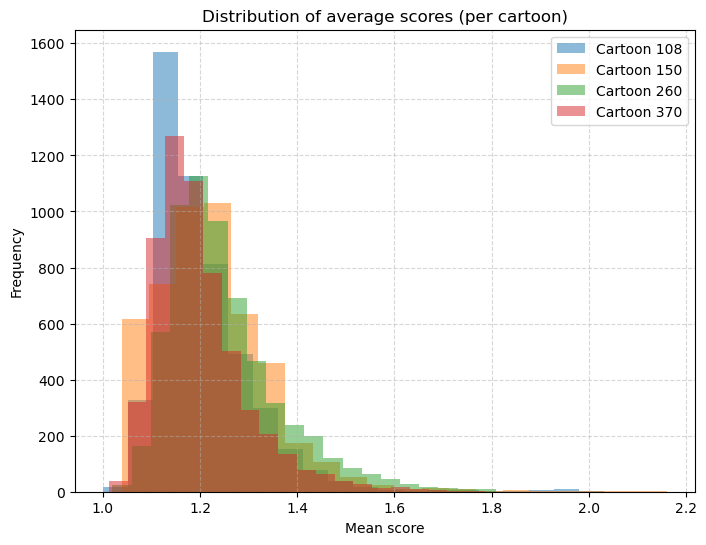

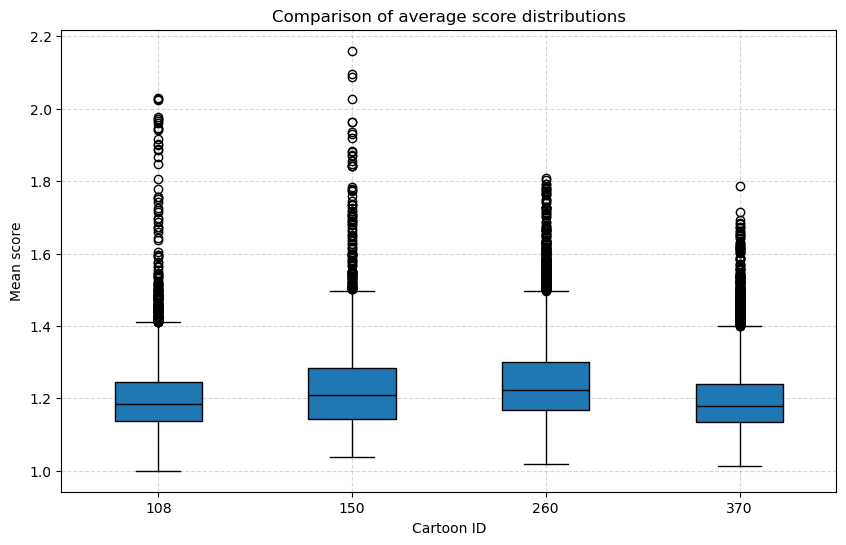

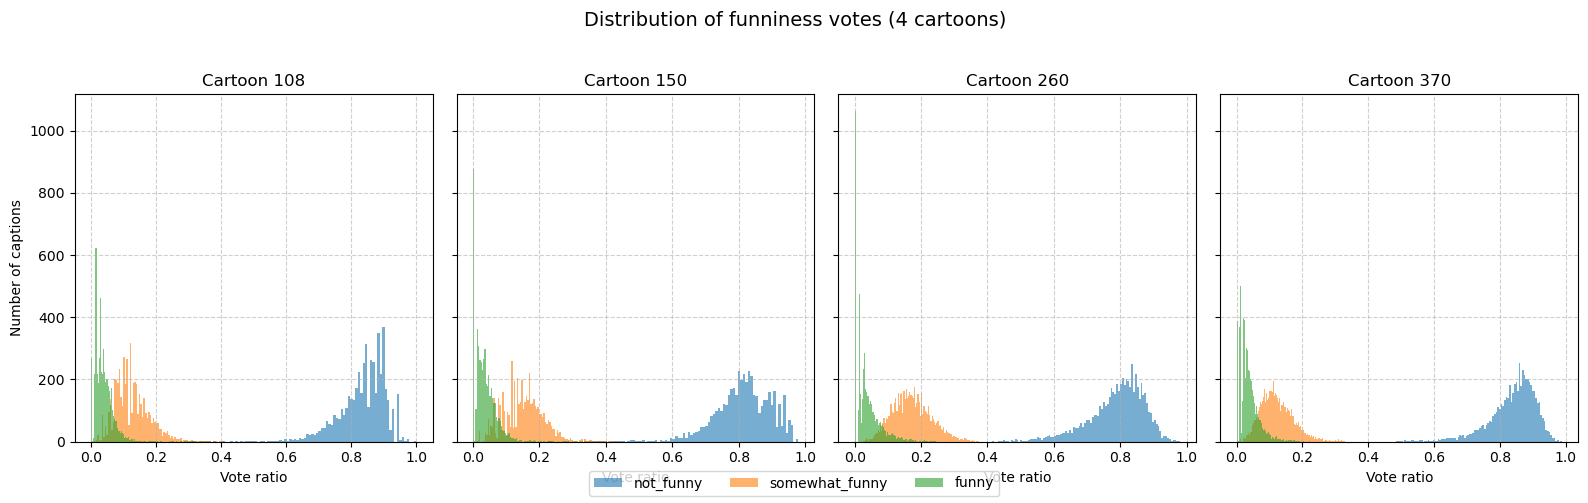

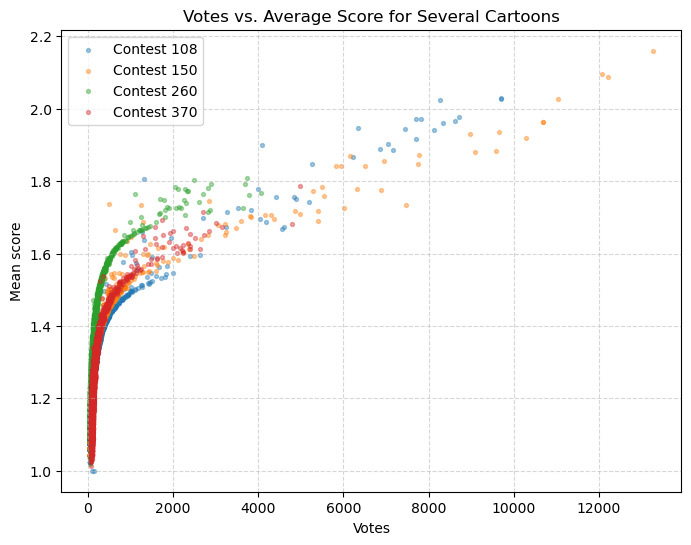

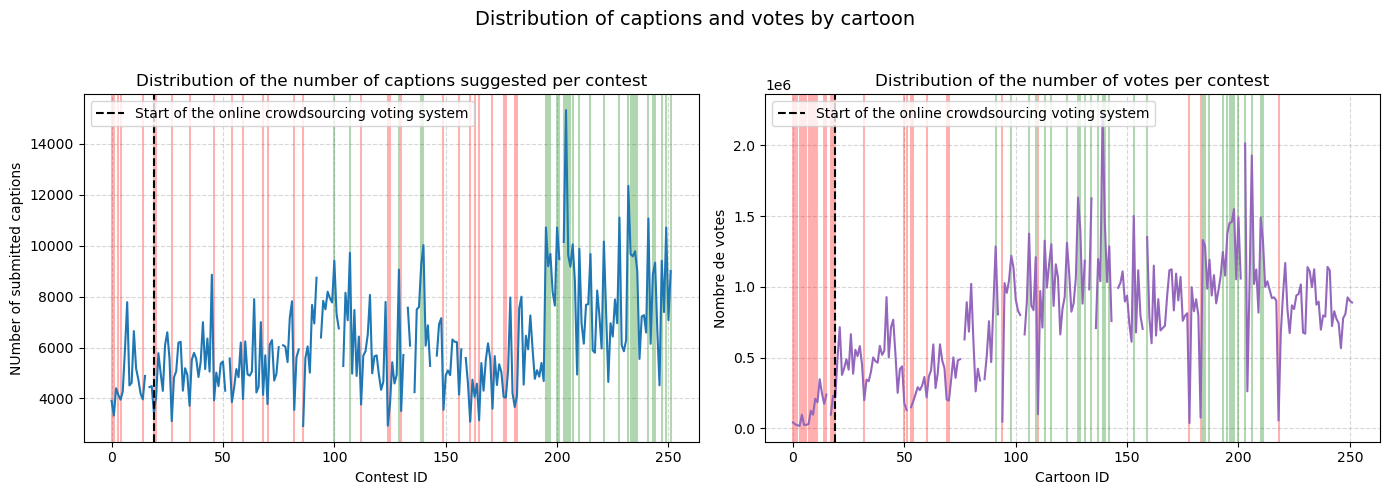

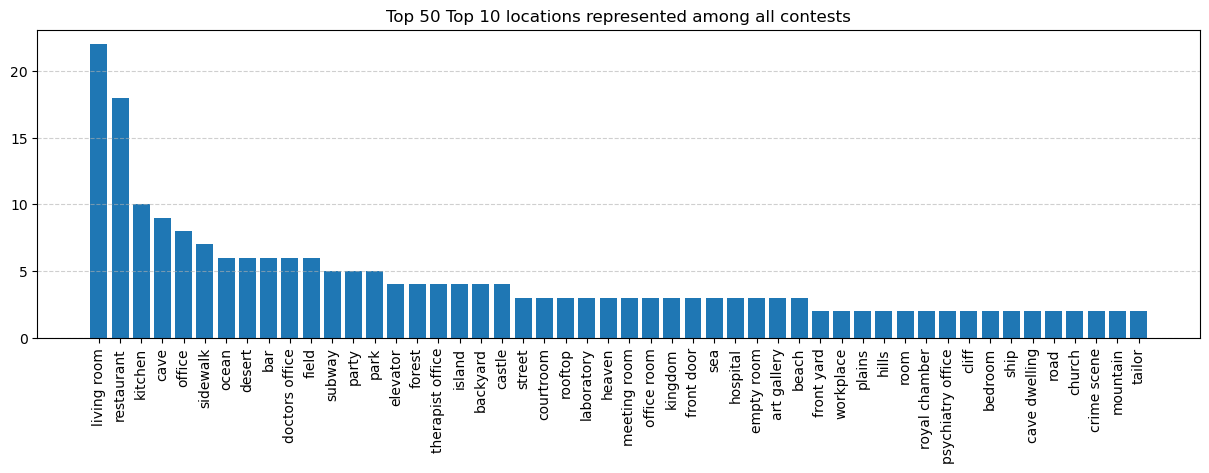

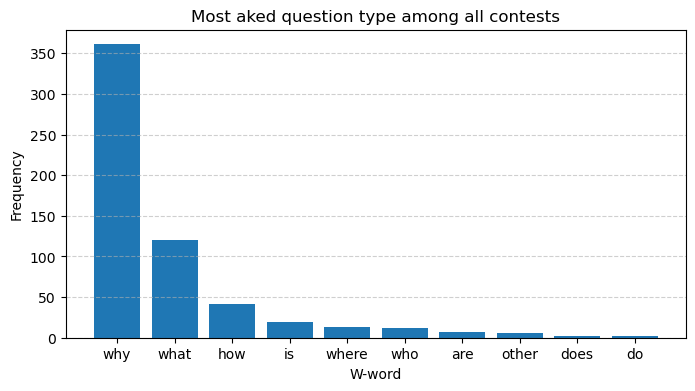

In [119]:
import src.scripts.descriptive_stats_tasks as dst

### On 1 single cartoon (dataA[108])

#1.2: histogram : avg score of all captions proposed + Kolmogorov–Smirnov test : normal distribution
histo = dst.plot_mean_histograms(dataA)
# 1.3: histogram : 'not_funny'/'somewhat_funny'/'funny' ratios among all captions, for the cartoon
dst.plot_funny_ratios(dataA)
# 1.4: avg score of the cartoon vs. number of votes
dst.plot_votes_vs_score(dataA)

### Plots/stats on all cartoons (dataC)

all_questions = [quest for sublist in dataC["questions"].dropna() for quest in sublist]
# 2.2: Number of captions submitted and number of votes vs. cartoon contest's id
dst.plot_captions_and_votes(dataC)
# 2.3.1: Top50 most cited Locations
top_locations = dst.plot_top_locations(dataC)
# 2.3.4: Top10 most used question's W-words
most_asked_question = dst.plot_question_types(all_questions)

### Comments about above graphs :

### Distributions
Those p-values really close to 0 shows a significant reject of the normal-distribution hypothesis. So the mean captions scores within a contest are not normally distributed. This is visible on the histrogram plots, it's probably a skewed or heavy-tailed distributions, typical of subjective rating data. The boxplots help us to see the skewness and outliers of data.

Consequence: Parametric tests (like the t-test) are not suitable. It will be better to use non-parametric tests to compare distributions. We can use the median and quartiles, which are more robust than the mean.

Concerning the ratios of 'funny'/'somewhat_funny'/'not_funny' for each captions, it also follows a skewed distribution, and we confirm locally what has been said for the complete dataset : people tend to vote mainly 'not_funny' (almost 80% of the time).

The plot of mean funniness scores vs number of votes help us to detect power-law effects : more voted captions tends to be more liked.


### Evolution of caption submission and number of votes with time
We can see in red the 30th less "participed" contest and "voted" contest, and in green the 30th most "participed" contest and "voted" contest. This helps us to detect periods of participations of the contest, and the impact of the beginning of the online crowdsourced voting system, increasing a lot the numbers of votes. We should therfore in our analysis normalize features by the number of participations.


### Top50 most cited Locations
This will help us to identify probably linked occupations.


### Top10 most used question's W-words
Most of the questions cited is "Why". This encourage us to think that uncanny pictures and situations provoque fun and jokes. We will see if those questions are correlated with better score.

## 3. Building usefull metrics

#### 3.1. Similarity metric

About the semantic embedding model used : The all-MiniLM-L6-v2 is a lightweight sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space (embeddings). It is designed for natural language understanding tasks like semantic search, clustering, and similarity comparisons, offering a balance of high performance and computational efficiency.

*Requirements:* ***pip install -U sentence-transformers***

In [106]:
from src.models.similarity_analysis import SimilarityModel, CaptionClustering, SimilarHumorAnalysis

# Just perform a 'naive' analysis on a random sample from a single cartoon for the moment. 
df = dataA[77].copy()
sample_size = None
if sample_size and len(df) > sample_size:
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)

We want to compare captions within the same contest and measure humorous clusters without ground truth. To address this, we:
- Use SBERT embeddings ('all-MiniLM-L6-v2'), this model is lightweight yet robust for capturing the semantic similarity of short phrases like captions.
- Perform clustering with Kmeans algorithm. The number of clusters should be determined by the elbow method, and the name of the labels are the different types of humour, found in the litterature.
- Vizualise the resulting clusters with a UMAP projection.

But one major challenge is we don't have ground truth label !
- To ensure density/semantic coherence, we calculate the average intra-cluster similarity (average of cosine similarities), and compare to the average inter-cluster average. A good cluster should have: Intra-cluster average > Inter-cluster average.
- We can do a qualitative inspection by visualizations of the similarity, with heatmaps per cluster. This should show homogeneous similarity values within clusters.
- Display the 2–3 captions closest to the center of the cluster (the “prototypes”). Display the 2–3 captions furthest from the center (the “outliers” of the cluster). Manually check if it makes sense in a humorous way.


We want to see if there is "winning clusters", depicting "winning humorous types and strategies". We will try to see if the captions most similar to the finalists are grouped together, or if certain clusters concentrate more “highly rated” captions.
- Plot the distribution of the means per clusters.
- For the moment NAIVE check if the humor scores are correlated with intra-cluster similarity (biases of observational studies will be later adressed with matching, bootstrapping technics), to see if there is 'better'/more funny clusters than others. Calculating the correlation between: The semantic distance between pairs of captions (1 - similarity), and the difference in humor score between these same pairs.

***To access to the definitions and content of classes SimilarityModel,***\
***CaptionClustering, SimilarHumorAnalysis, please see : [here](src\models\similarity_analysis.py)***

## 3.2. Plots

SBERT encoding with 'all-MiniLM-L6-v2'


Batches: 100%|██████████| 191/191 [01:21<00:00,  2.35it/s]


KMeans clustering with 50 clusters


c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


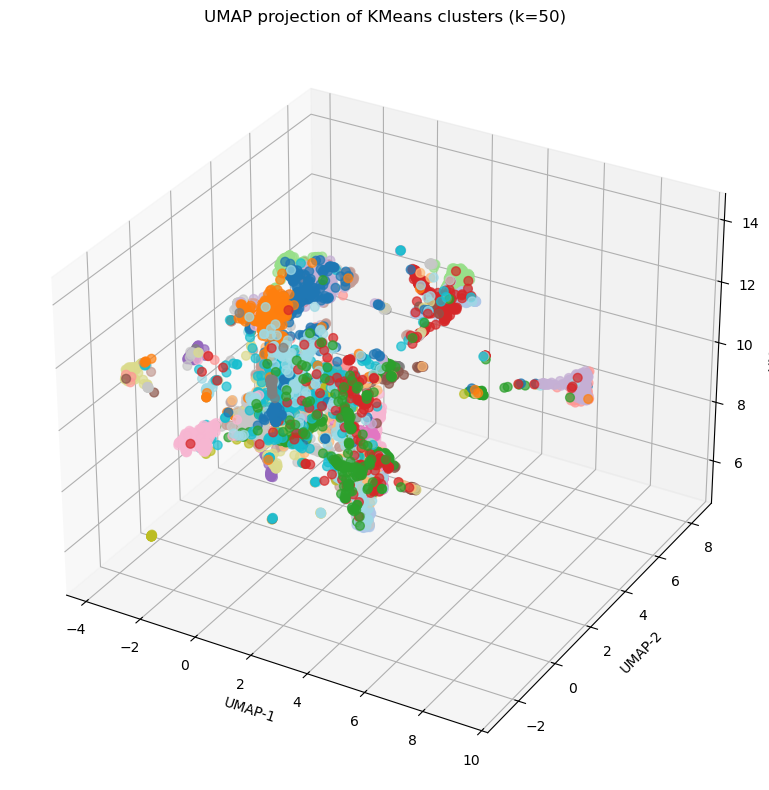

In [108]:
# 1.Clustering
cluster_model = CaptionClustering(model_name='all-MiniLM-L6-v2', n_clusters=50, normalize=True)

cluster_labels, embeddings = cluster_model.cluster_captions(df)
df_clusters = cluster_model.UMAP_reduction(df, umap_n_components=3, umap_n_neighbors=15, umap_min_dist=0.1, umap_metric='cosine')


For the moment, no fine-tuning of hyperparameters has been not (but will be done later!) so the clusterisation is really not perfect. But still, the UMAP projection shows that there is clusters.

Cluster 14: 143 captions — mean combined similarity = 0.572


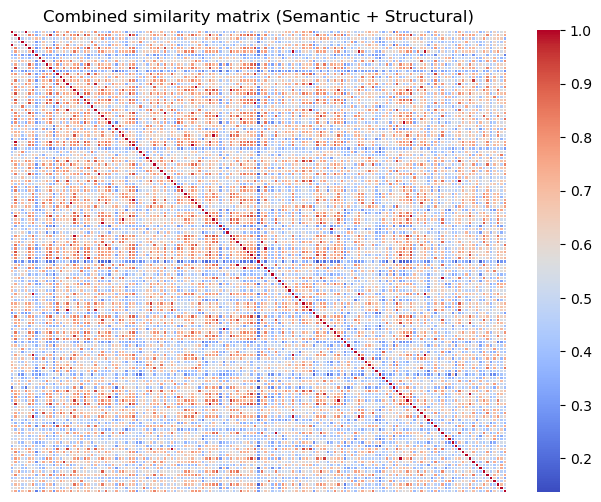

Cluster 43: 70 captions — mean combined similarity = 0.366


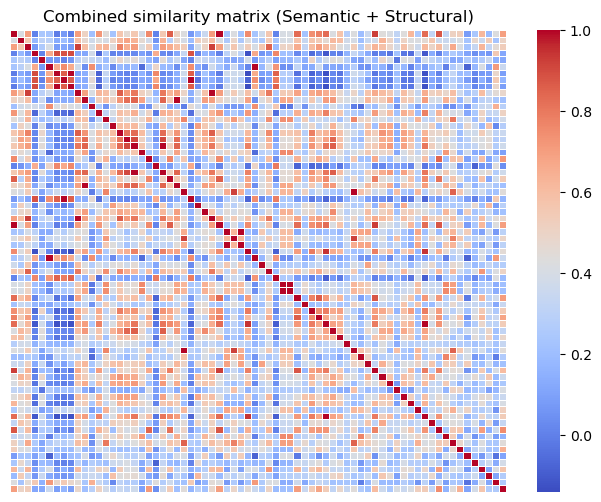

Cluster 44: 74 captions — mean combined similarity = 0.529


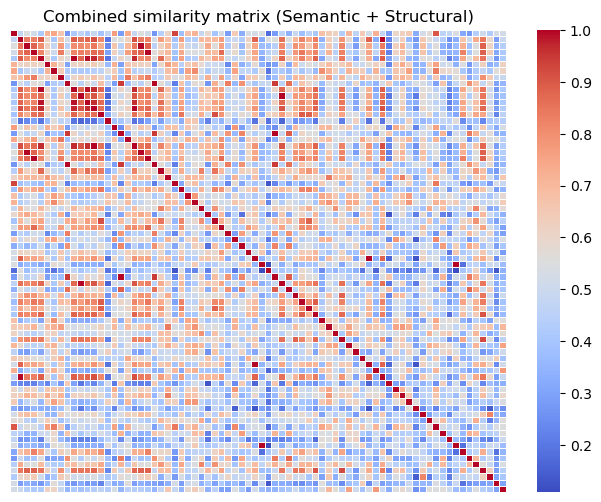

Cluster 49: 152 captions — mean combined similarity = 0.210


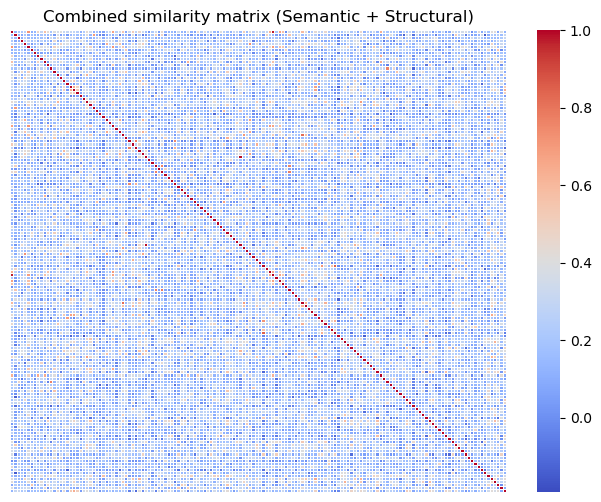

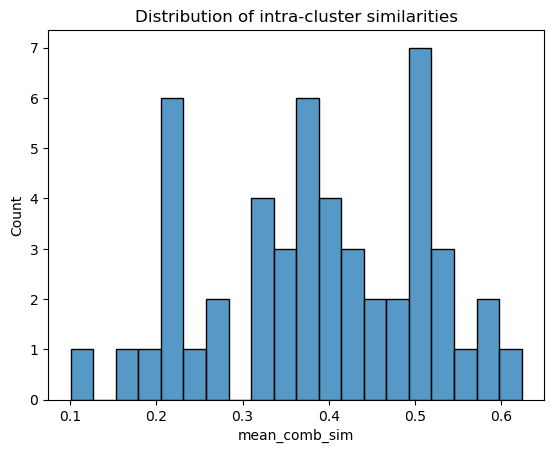

In [109]:
# 2 Analysis of similarity of captions within each clusters to see if the clustering with kNN is working or assigning not good clusters
sim_results = cluster_model.evaluate_intra_cluster_similarity(df, plot=[14, 43, 44, 49])

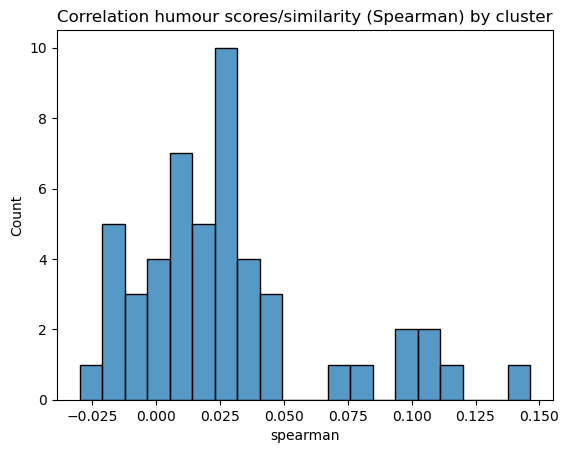

In [110]:
# 3 Analysis of humour score correlation within a similarity cluster
humor_analysis = SimilarHumorAnalysis(model_name='all-MiniLM-L6-v2')
corr_results = humor_analysis.scores_correlation_by_cluster(df_clusters, humor_col='mean')
#print(corr_results.sort_values('spearman', ascending=False).head())

### 3.3. Comments

We see a possible clusterisation, with intra-cluster homogeneity concerning the similarity metric (see heatmaps). The results are not the most satisfactory for the moment :
- Results of similarity homogeneity depends a lot of the cluster : some contains very similar captions, some not (see histogram of distribution).
- The naive correlation analysis shows mainly no correlation between the clusters of captions and the scores obtained within the cluster, some clusters have a very small correlation.

The models will be enhanced with fine-tuning of the SBERT model and Kmeans hyperparameters (e.g. choosing adequate number of cluster with Elbow method, distance metric...).


Limitations of this similarity metric, that has to be adressed for milestone 3:
- SBERT embeddings don't capture all humor, they "only" capture semantic proximity, not humorous style (e.g., irony, absurdity, subversion, etc.). --> Two captions that are very funny for the same reason (e.g., puns) can be very far apart semantically.

- Intra-cluster similarity isn't always enough: a cluster can be "compact" (high average similarity) but thematically irrelevant (e.g., very banal or repetitive captions).

<center>
    <img src="data/newyorker_caption_contest_virgin/images/612.jpg" alt="New Yorker Cartoon" style="width:350px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

##### From those diverse steps, statistic results and metric tools, we can now dive into our data story, yay !

## 4. Narrative Flow

### 4.1. Axis 1 – What Is Considered Funny

The first step was to examine how the funny scores were distributed. From the figure below, which sums all votes for each category across all captions, we can clearly see that the number of votes for not_funny is much higher than for the other categories. This skewed distribution means that computing the mean would be biased toward 1. To address this, a new metric for funniness was developed (see the mathematical specification in Section 1.2), which is more resilient to the high number of negative votes. With this metric, we focus solely on what people find genuinely funny, without taking into account the "somewhat funny" votes. To demonstrate the effectiveness of this metric, the top captions across the dataset are presented, first sorted by their mean and then by the new funny_score.

Total votes: not_funny         210747483
somewhat_funny     57140251
funny              23212253
dtype: int64


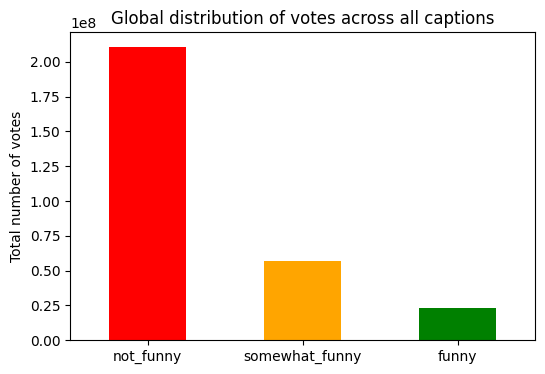

### Top 5 Captions by Mean Score

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,funny_score,rank_funny_overall
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,88,38.599534,1.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,178,27.944338,4.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,43,31.574538,3.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,153,33.593560,2.0
29909,Who'd have thought they'd get you for tax evas...,2.391304,0.174898,23,5,4,14,7,13.971382,438.0


### Top 5 Captions by Funny Score

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,funny_score,rank_funny_overall
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,88,38.599534,1.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,153,33.593560,2.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,43,31.574538,3.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,178,27.944338,4.0
1041265,Looks like you're already familiar with the si...,2.387410,0.005740,14726,1941,5211,7574,188,27.179467,5.0


### Last 5 Captions by Funny Score

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,funny_score,rank_funny_overall
415724,"We're not getting Shakespeare, but about every...",1.0,0.000155,6467,6467,0,0,80,-10.767739,2292678.0
415727,"Ever so subtly, Ed began to push his right win...",1.0,0.000157,6377,6377,0,0,80,-10.740842,2292677.0
415722,I'm pretty sure I said 'hackers'.,1.0,0.000157,6366,6366,0,0,80,-10.737528,2292676.0
415720,I am concerned that this project could go sout...,1.0,0.000157,6359,6359,0,0,80,-10.735417,2292675.0
415719,They want to know if they can work remotely du...,1.0,0.000158,6313,6313,0,0,80,-10.721483,2292674.0


,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,funny_score,rank_funny_overall
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,0,8.522454,3074.0
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,0,7.412505,4679.0
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,0,5.890651,9372.0
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,0,4.492067,21567.0
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,0,5.252752,13621.0


In [17]:
from src.utils.function_axis_1 import plot_global_vote_distribution
from src.utils.function_axis_1 import compute_funny_ranking
from IPython.display import display, Markdown
for i, df in enumerate(dataA):
    df['source_df'] = i  # i  allow to keep the informatio of which images the caption is related to

dataA_merged = pd.concat(dataA, ignore_index=True) # Data merging to assess all captions together


plot_global_vote_distribution(dataA_merged)

dataA_merged = compute_funny_ranking(dataA_merged)

Mean_best = dataA_merged.sort_values(["mean"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Mean Score"))
display(Mean_best)

Funny_score_best = dataA_merged.sort_values(["funny_score"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Funny Score"))
display(Funny_score_best)

Funny_score_worst = dataA_merged.sort_values(["funny_score"],ascending=True).head(5)
display(Markdown("### Last 5 Captions by Funny Score"))
display(Funny_score_worst)

dataA_merged.head()

From the top captions above, we can see that the new metric reshuffles the ranking to provide a more intuitive order. For instance, the second caption becomes "Lunch on me," which received 15,232 funny votes but had a lower mean than other captions with fewer voters. This demonstrates that the new metric better reflects the true funniness of each caption.

Similarly, for the lowest-ranked captions, our metric outperforms the mean. Using the mean, all poorly rated captions scored 1, failing to distinguish the very worst captions from the rest. With the new metric, captions with more votes carry greater weight, so the lowest-ranked captions are those that were overwhelmingly voted as not funny, as shown in the final DataFrame above.

### 4.2. Axis 1 – Professions, Politics, and Power

**Professions in Humor:**  
Which jobs are depicted most often? Which are ridiculed vs. admired? What stereotypes are recurrent (e.g., lawyers as tricksters, doctors as saviors)?  

**Politics in Humor:**  
Do captions reflect partisan leanings (Democrat vs. Republican) or mock political figures more broadly? Are political jokes rated differently? What is the temporal behaviour of political topics in captions?  

So far, the research that was conducted here takes the tokenised & lemmatised dataset, and performs a count on all occupations that occur in the [occupation list](data\final_combined_occupations.csv) created in section 1.3, and in the captions. The procedure is showed below and note that this code allows us to find multi-word occupations.

In [6]:
#loading data
from src.scripts.axis2 import *

dataA1, dataC1, dataA_startID, dataA_endID, dataC_lastGoodID = load_newyorker_data(filepath=STORED_DATAPREPNOUNS_PKL_PATH)

occupations_df = load_occupations(filepath=OCCUPATIONS_CSV_PATH)


Data loaded successfully.


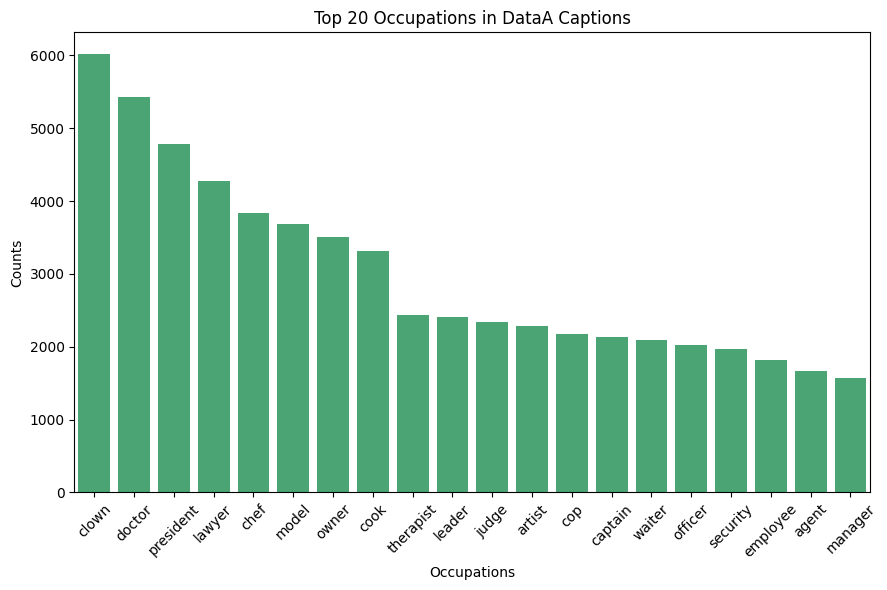

In [7]:
#Create dictionary mapping synonyms to occupation
occupations = occupations_df['Occupation']
synonyms_list = occupations_df['Synonyms'].tolist()
syn_to_occ = {
    synonym.lower(): occ
    for occ, synonyms in zip(occupations, synonyms_list)
    for synonym in synonyms
}

# extracting occupations in new column
extract_occupations_captions(dataA1, syn_to_occ, colname = 'occupation_counts', col_origin = 'cleaned_caption')


#counting occupations in caption
occupation_totals = count_occupation_occurrences_captions(dataA1, col='occupation_counts')

#print(f"The most common occupations found in DataA captions are:\n")
#print(occupation_totals.most_common(100))
#print("\n\n")

#plot histogram of top 20 occupations
top20 = occupation_totals.most_common(20)
occupations, counts = zip(*top20)
barchart(list(occupations), list(counts), title="Top 20 Occupations in DataA Captions", xlabel="Occupations", ylabel="Counts", color = 'mediumseagreen')


After this is done, one might say that some of the "jobs" that are found are not real professions. For example "clown" can also be seen in other ways. To remedy this in some way, the nouns can be extracted from the tokenised column. Again, the nouns were extracted using [this code](src\data\extract_nouns.py), but the obtained pickle is not in the repo. Another issue with this code is that we cannot look for occupations that are multi-worded, but the previous code showed that the most frequent mentioned are single-worded. The obtained figure is shown below.

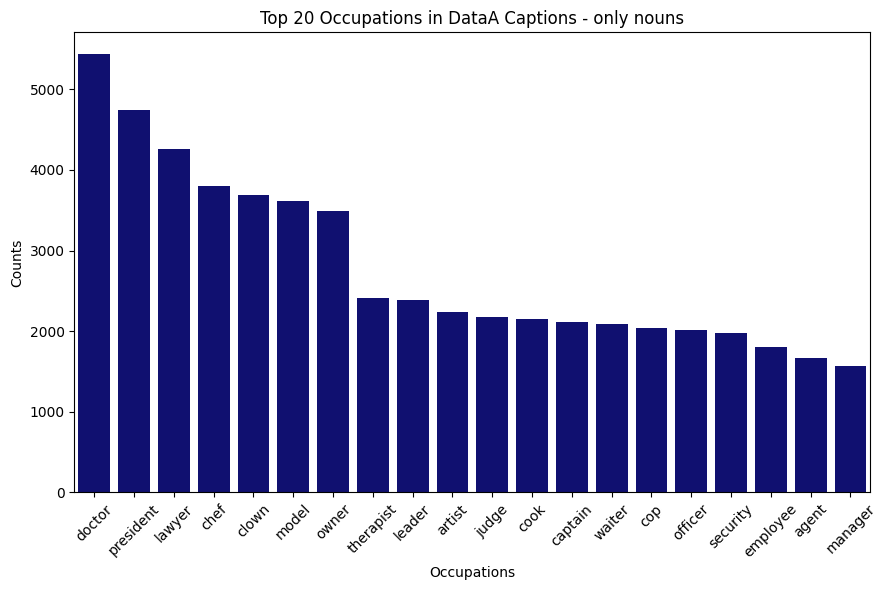

In [8]:
# extracting occupations in new column
extract_occupations_captions(dataA1, syn_to_occ, colname = 'occupation_counts_nouns', col_origin = 'captions_nouns')

#counting occupations in caption
occupation_totals = count_occupation_occurrences_captions(dataA1, col='occupation_counts_nouns')

#print(f"The most common occupations found in DataA captions are:\n")
#print(occupation_totals.most_common(100))
#print("\n\n")

#plot histogram of top 20 occupations
top20 = occupation_totals.most_common(20)
occupations, counts = zip(*top20)
barchart(list(occupations), list(counts), title="Top 20 Occupations in DataA Captions - only nouns", xlabel="Occupations", ylabel="Counts", color = 'navy')

We see that clown is not the funniest, though still quite high up there. To be continued...

Something to keep in mind when choosing a career path: being a doctor, lawyer or president makes you made fun of a lot.

#### 'Temporal' analysis

Here are some exploratory analyses that are good to keep in mind for the following work that will be done within this axes. 

Let check how often and in which contests do occupationss occur first. Are there any without any occupations?

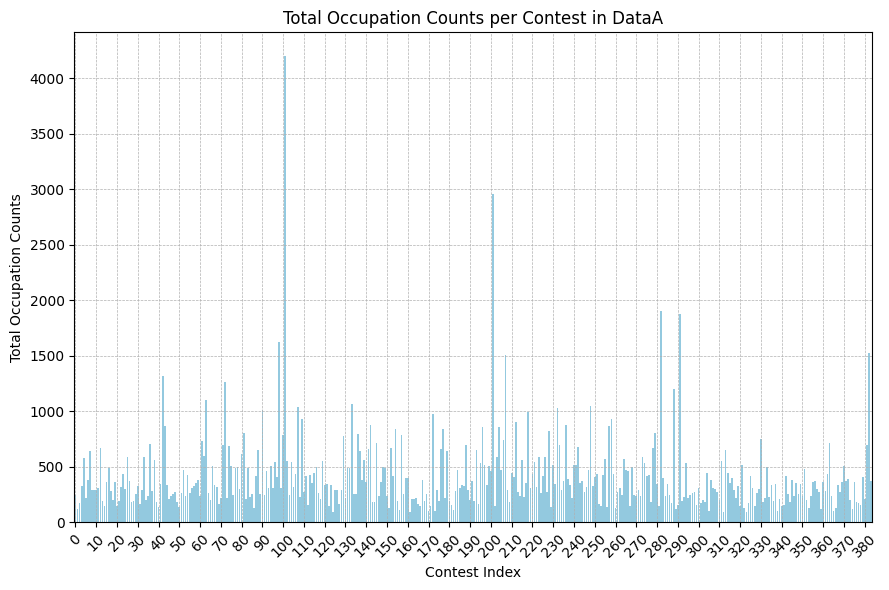

In [9]:
occupation_counts_list = occupation_counts_per_contest(dataA1, col = 'occupation_counts')

#plot
x = list(range(len(occupation_counts_list)))
y = occupation_counts_list 
plt.figure(figsize=(9, 6))
sns.barplot(x=x, y=y, color='skyblue')
plt.title("Total Occupation Counts per Contest in DataA")
plt.xlabel("Contest Index")
plt.ylabel("Total Occupation Counts")
plt.xticks(np.arange(0,len(occupation_counts_list), step = 10), rotation=45)
plt.tight_layout()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
# Are there some contests with no occupations at all?
contests_with_no_occupations = [i for i, count in enumerate(occupation_counts_list) if count == 0]

print(f"Contests with no occupations found: {contests_with_no_occupations}")

Contests with no occupations found: []


Lets check the temporal evolution of the number of job occurences in captions.

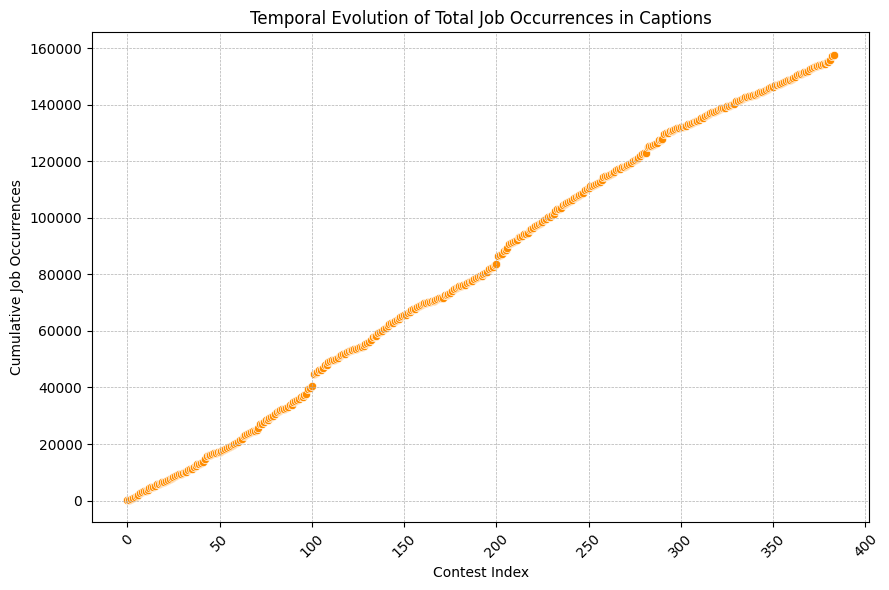

In [11]:
# Temporal evolution of total number of job occurences in captions
sum_occupations_over_time = []
sum_ = 0
for i in range(len(dataA1)):
    sum_ += occupation_counts_list[i]
    sum_occupations_over_time.append(sum_)

x = np.arange(0, len(sum_occupations_over_time))
y = sum_occupations_over_time
scatterplot(x,y, xlabel = 'Contest Index', ylabel = 'Cumulative Job Occurrences', title = 'Temporal Evolution of Total Job Occurrences in Captions', color = 'darkorange')

We see a large jump in the number of captions near the 100th contest. This is discussed further on.

Let us look at the ratio of occupation mentions in captions to captions with no mention of occupations. 

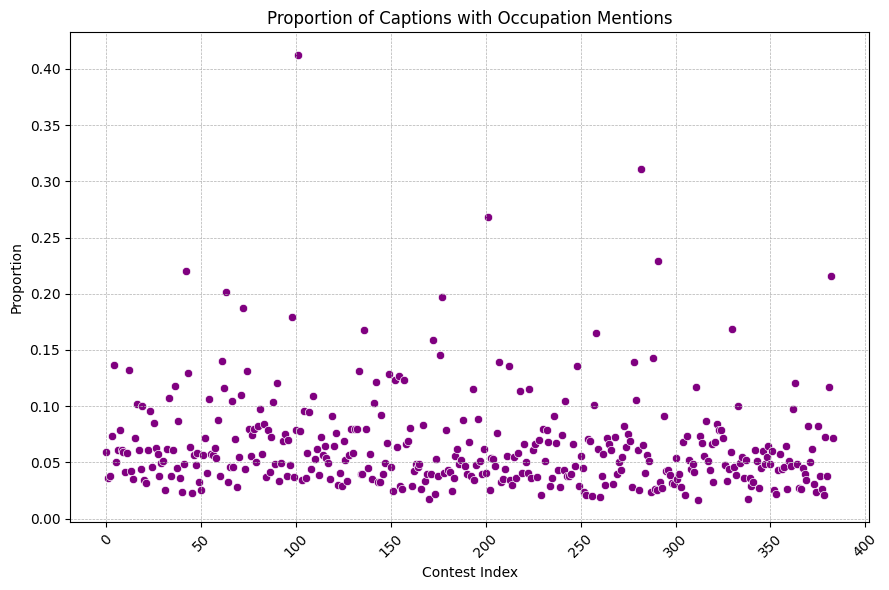

In [15]:
# ratio of captions with occupations to captions without occupations
caption_counts_with_occupations = []
caption_counts_without_occupations = []
for i in range(len(dataA1)):
    df = dataA1[i]
    count_with = sum(1 for counts in df['occupation_counts'] if len(counts) > 0)
    count_without = sum(1 for counts in df['occupation_counts'] if len(counts) == 0)
    caption_counts_with_occupations.append(count_with)
    caption_counts_without_occupations.append(count_without)

ratios = [with_occ / (without_occ + 1e-6) for with_occ, without_occ in zip(caption_counts_with_occupations, caption_counts_without_occupations)]
proportions = [with_occ / (with_occ + without_occ + 1e-6) for with_occ, without_occ in zip(caption_counts_with_occupations, caption_counts_without_occupations)]

#x = np.arange(len(ratios))
#scatterplot(x, ratios, xlabel = 'Contest Index', ylabel ='Ratio', title = 'Occupation Mentions Ratio in Captions', color = 'mediumseagreen')
x = np.arange(len(proportions))
scatterplot(x, proportions, xlabel = 'Contest Index', ylabel ='Proportion', title = 'Proportion of Captions with Occupation Mentions', color = 'purple')

On this graph we see that there are some contests with a high proportion of captions which contain occupations. These could correspond to contests where the image contains an actual job. This is further explored below.

Finally, let us look at how jobs occur in the description of images and the uncanny descriptions too. These are all in `dataC`, and we can compare to the evolution found in the captions in `dataA`. I will count the number of unique jobs that occur in an image description. Note that synonyms are not dealt with right now, so "policeman" and "cop" count as different jobs.


384
240


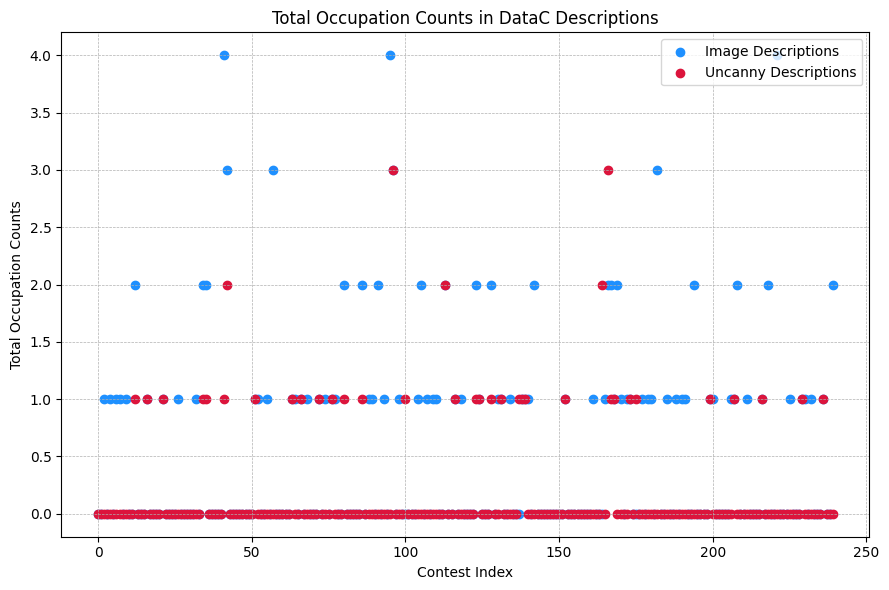

In [13]:
#remove all NaN values
print(len(dataC1))
dataC1 = dataC1.dropna(subset='image_descriptions').reset_index(drop=True)
print(len(dataC1))

extract_occupations_captions(dataC1, syn_to_occ, colname = 'occupation_counts_image_descriptions', col_origin = 'cleaned_image_descriptions')
extract_occupations_captions(dataC1, syn_to_occ, colname = 'occupation_counts_uncanny_descriptions', col_origin = 'cleaned_image_uncanny_descriptions')

nr_occupations_image_descriptions = [len(dataC1.loc[i, 'occupation_counts_image_descriptions']) for i in range(len(dataC1))]
nr_occupations_uncanny_descriptions = [len(dataC1.loc[i, 'occupation_counts_uncanny_descriptions']) for i in range(len(dataC1))]


plt.figure(figsize=(9, 6))
plt.scatter(np.arange(len(nr_occupations_image_descriptions)), nr_occupations_image_descriptions, marker='o', color='dodgerblue', label='Image Descriptions')
plt.scatter(np.arange(len(nr_occupations_uncanny_descriptions)), nr_occupations_uncanny_descriptions, marker='o', color='crimson', label='Uncanny Descriptions')
plt.title("Total Occupation Counts in DataC Descriptions")
plt.xlabel("Contest Index")
plt.ylabel("Total Occupation Counts")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.show()

We can check where does at least one occupation occur, in either the uncanny description or the normal image description

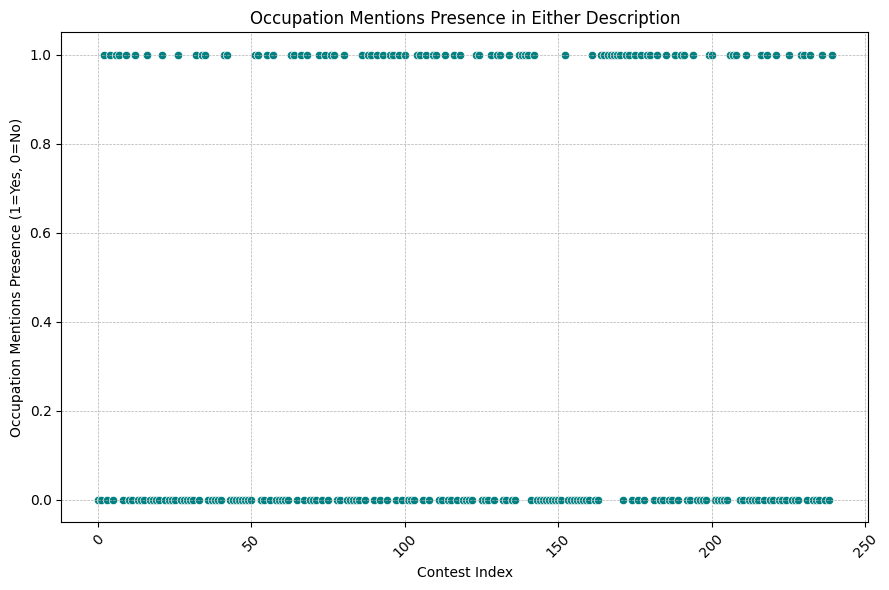

Number of contests with occupation mentions in either description: 91 out of 240


In [14]:
occupation_presence_image_descriptions = dataC1['occupation_counts_image_descriptions'].apply(has_occupation).astype(int)
occupation_presence_uncanny_descriptions = dataC1['occupation_counts_uncanny_descriptions'].apply(has_occupation).astype(int)

# Either one has occupations
either = (occupation_presence_image_descriptions | occupation_presence_uncanny_descriptions).astype(int)


scatterplot(np.arange(len(either)), either, xlabel = 'Contest Index', ylabel = 'Occupation Mentions Presence (1=Yes, 0=No)', title = 'Occupation Mentions Presence in Either Description', color = 'teal')

print(f"Number of contests with occupation mentions in either description: {either.sum()} out of {len(either)}")


So we see that we only have occupations occuring in the image (or at least its description) in $38\%$ of the captions, while we have jobs occuring in every caption contest. A future comparison would be to look at how the mentioned jobs in the metadata influence the number of occurences of jobs in captions, and if the jobs in the captions are the same as in the metadata or not. Remember to keep in mind, the metadata is much smaller than the caption dataset, so compare only relevant contests!

The three final graphs show that there is an outlier near the 100th contest, yet there are no or mentions of occupations in the metadata for this image (or maybe one in the uncanny description). It would be interesting to see what is happening here, and will be analysed later in the project.

The code above has some shortcomings, especially concerning the occupations list: it can still be enriched, the cleaning produced some entries which are not occupations, there are some trailing commas that were not removed, and one of the datasets has wording that needs to be corrected (something like "driver lorry" instead of "lorry driver").

The future studies will deal with:
- Performing an analysis about the metadata: do occupations only occur when the job is depicted in the cartoon?
- What occupations are ridiculed/admired? Are there recurring stereotypes?
 - This will focus on words co-occuring with occupations in the text.
- **Politics in Humor**
    - Here a similar database must be created like the occupations. This will be considerably shorter, as there is less clearly political text that we can identify.
    - A preliminary analysis based on a small list of political words is shown below. This will be repeated later with a more complete list of political words, and "left" and "right" will be taken out as they are not only political terms, and can lead to mis-interpretation of data.
    - Timeline of mentions of political figures / parties.  
    - Sentiment distribution around Democrats vs. Republicans.  
    - Example “political joke clusters” side by side with major events (e.g., elections).

### 4.3. Gender Roles

In [8]:
# Create the instance of our class that contains all of the functions needed for this analysis
ga = GenderAnalysis()

# remove remaining NaN in rows (if there exists any)
no_NaN, dataC0 = ga.remove_nan(dataC)

#### Basic plots

**Methodology**

- How often men/women appear in the cartoon ? 

    a. To recognize if a man/woman is in the picture, the idea is to use the *image_descriptions* and *uncanny_image_descriptions* that are contained in the metadata. **For some contest we don't have this metadata**, so for now, we will not use these ones. I defined two lists with general terms associated with each gender to detect the mention of gender in an image. It is a simple method for now, might evolve later.

    b. When this is done, I can do several plots. The first being a bar plot with just the distribution of gender over all the cartoons. Then I can plot the evolution of the gender distribution over time, to see if it is constant or not. 

- How often men/women are mentionned in the captions ?

    **Remark:** Since there are a lot of caption for each contest, to simplify this basic analysis, I'll look only in the top ten most voted captions. To do this, I find the mention of man/women in the captions with the same list ad for the catoon.

    c. Same as 0.b, do some plots of the overall contest and then evolution over the years.

- Are men more mentionned when there is a man in the picture or not, same for women ? Are men mentionned in the caption even if there are no men in the picture, same for women ? Does the humor around one gender depends on referencing the other ? 

    Added a simple “co-occurrence” heatmap → e.g., men in image × women in caption, women in image × men in caption.

In [9]:
dataC1 = ga.get_metadata(dataC0)

count, dataTop10 = ga.get_Top10_captions(dataA, no_NaN)

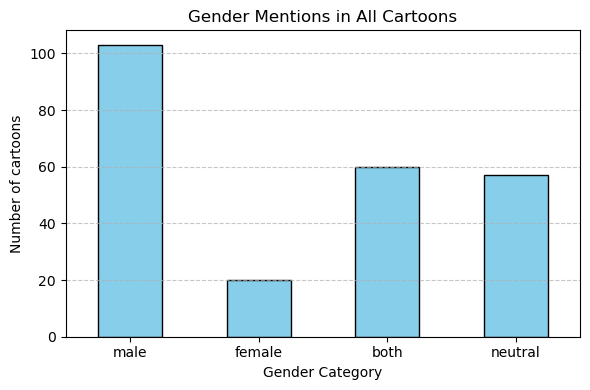

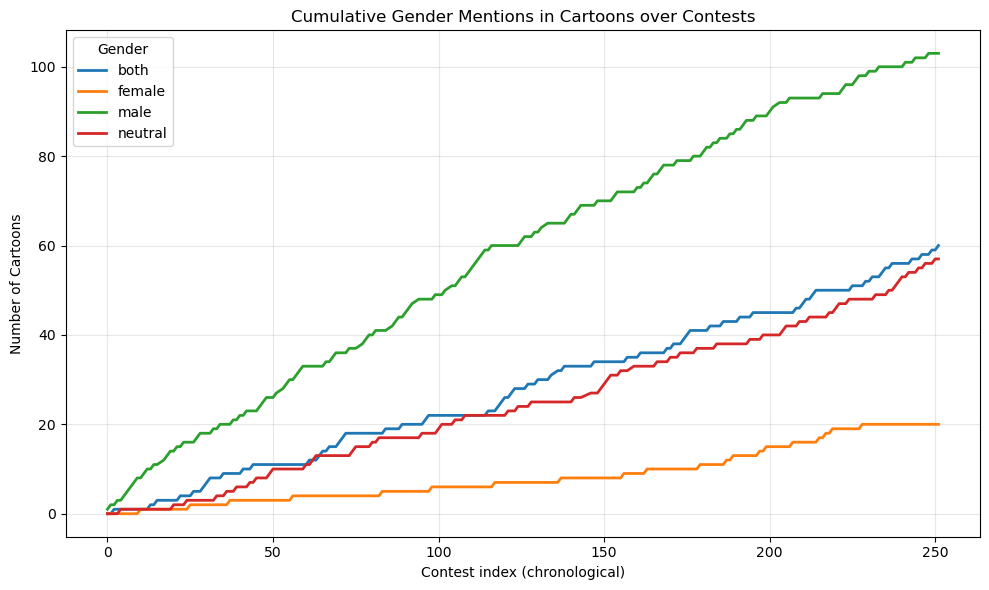

In [10]:
# How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC1['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot Overall counts
ga.plot_overall_counts(
    gender_counts,
    title="Gender Mentions in All Cartoons",
    xlabel="Gender Category",
    ylabel="Number of cartoons"
)

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC1)),
                   "gender_mention": dataC1['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    counts,
    title="Cumulative Gender Mentions in Cartoons over Contests",
    xlabel="Contest index (chronological)",
    ylabel="Number of Cartoons",
    legend_title="Gender"
)


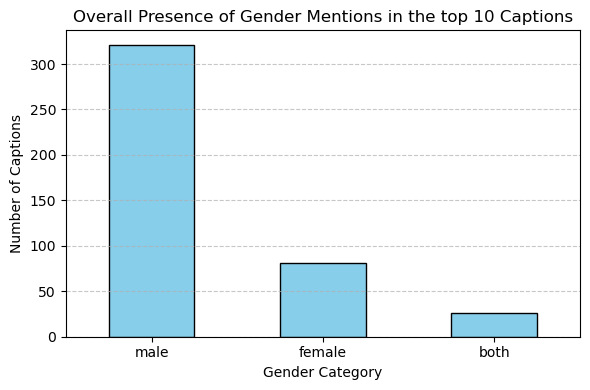

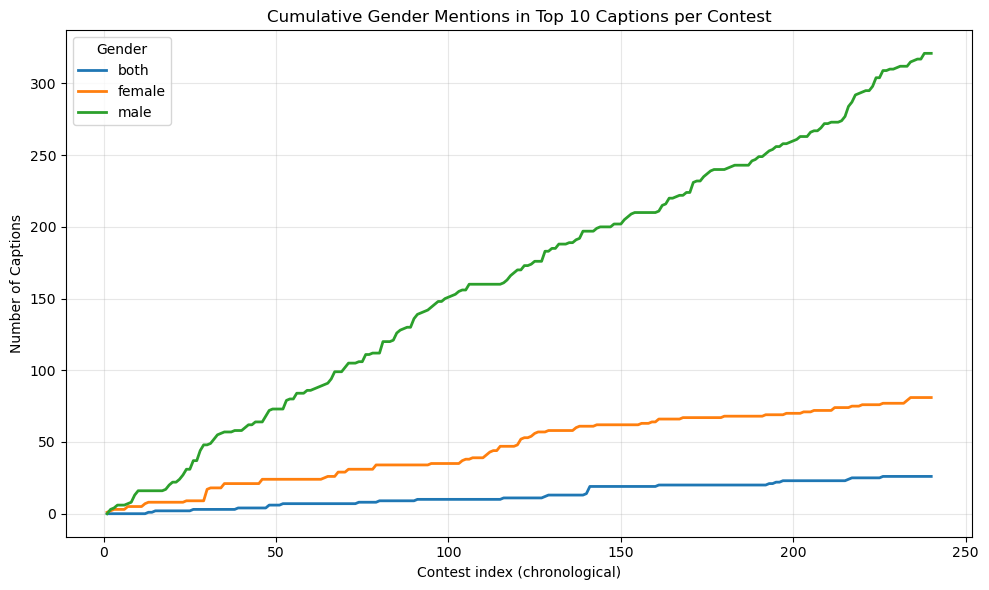

In [11]:
# How often men/women are mentionned in the top 10 captions

overall_counts, pivoted = ga.distribution_captions(count)

# In the plots I don't show the neutral, because it is a huge number compared
# to the other categories

# Plot Overall counts
ga.plot_overall_counts(
    overall_counts,
    title="Overall Presence of Gender Mentions in the top 10 Captions",
    xlabel="Gender Category",
    ylabel="Number of Captions",
    neutral = False
)

# Evolution over time
cumulative = pivoted.cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    cumulative,
    title="Cumulative Gender Mentions in Top 10 Captions per Contest",
    xlabel="Contest index (chronological)",
    ylabel="Number of Captions",
    legend_title="Gender",
    neutral = False
)

Let's look at cross-relationships between gender in the image and gender in the caption. Here we'll look at this relationship for the top voted caption.

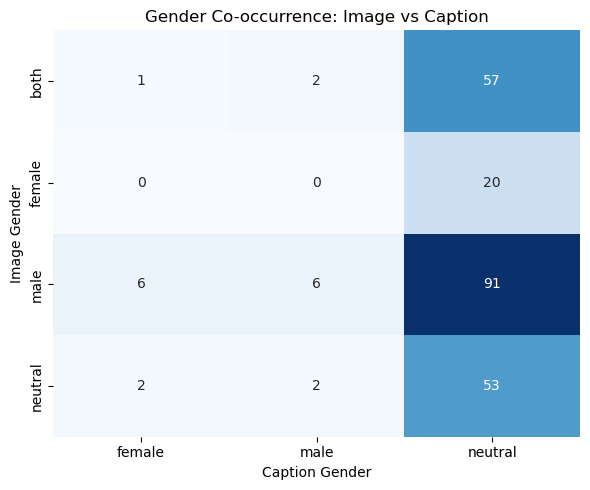

In [12]:

cross = ga.compute_crosstab(no_NaN, dataA, dataC1)

ga.plot_gender_cooccurrence(cross, title = "Gender Co-occurrence: Image vs Caption", 
                            xlabel="Caption Gender",
                            ylabel="Image Gender")

With these initial plots, it is clear that we can reliably detect the genders associated with both cartoons and captions.

We observe that men are mentioned about five times more frequently than women as the sole gender. 

Looking at the gender distribution across all selected captions, most are gender-neutral, while the next most frequent mentions are of men—consistent with the fact that many cartoons primarily depict male characters.

#### How are men vs women depicted ?

For this, we followed the methodology of Neal Caren in this site: https://nealcaren.github.io/text-as-data/html/times_gender.html. He studied how the Times writes about men and women.

Here is the methodology: 

- Split text into units: Divide the text into sentences or other meaningful segments for analysis.

- Define gender indicators: Create lists of words or phrases that signal the presence of each category

- Label each unit: Assign a label to each sentence based on which category indicators it contains (e.g., “male,” “female,” “both,” or "neutral").

- Tokenize and clean text: Break sentences into words, removing proper nouns, stop words, and the indicator words themselves.

- Count word frequencies by category: Compute how often each word appears in sentences labeled with each category.

- Normalize frequencies: Adjust word counts by the total number of words in each category to make comparisons fair.

    $ S_{w}^{\text{male}} = \dfrac{\tfrac{c_{w,m}}{N_m}}{\tfrac{c_{w,m}}{N_m} + \tfrac{c_{w,f}}{N_f}} $

    Where:  
        - $ S_{w}^{\text{male}} $ — normalized "male share" score for word w ; the proportion of the word's usage associated with male-subject sentences.  
        - $ c_{w,m} $ — count of occurrences of word w in male-subject sentences.  
        - $ c_{w,f} $ — count of occurrences of word w in female-subject sentences.  
        - $ N_m $ — total number of words (tokens) across all male-subject sentences.  
        - $ N_f $ — total number of words (tokens) across all female-subject sentences.  


- Identify associations: Find words that are disproportionately frequent in one category compared to others.

- Visualize results: Display the strongest associations, with word clouds, to show which words are most linked to each category.

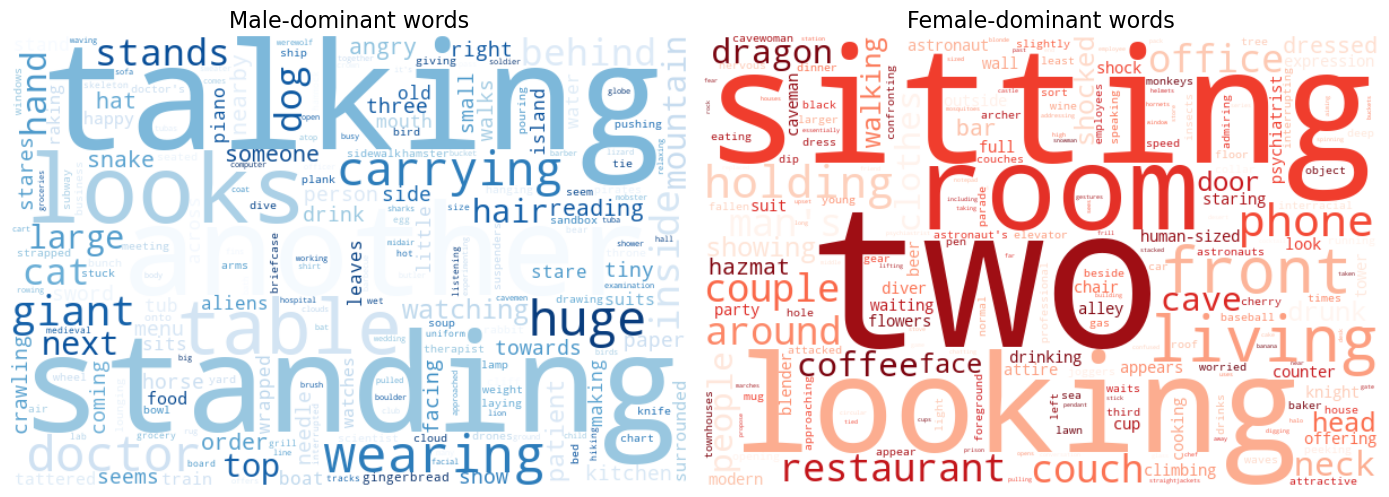

In [16]:
# loading results based on this analysis

# wordcloud on the words that were most associate with man or woman

with open(r"src\data\gender_roles_data\male_freq.json") as f:
    male_freq = json.load(f)

# --- Generate the word clouds ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=200,
    stopwords=ga.STOPWORDS
).generate_from_frequencies(male_freq)

with open(r"src\data\gender_roles_data\female_freq.json") as g:
    female_freq = json.load(g)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200,
    stopwords=ga.STOPWORDS
).generate_from_frequencies(female_freq)

# # --- Display both word clouds side by side ---
ga.plot_wordclouds(male_cloud, female_cloud)

The purpose of this word cloud is to highlight the words most frequently associated with each gender in the cartoons and captions. 

By examining these associations, we can begin to understand the roles and traits attributed to men and women within this specific cultural context. 

If someone’s only exposure to gender roles in society came from these cartoon descriptions, the word cloud gives a sense of what impressions they might form about men and women. 

Additionally, this visualization provides an initial lens to explore whether common stereotypes are present, and if so, how they are reinforced or challenged within the contest.

# A big thank you for this lecture !

# What is the answer to ADA, the universe and everything ?

In [12]:
import random

answer = None
number_of_tries = 0
while answer != 42:
    # Generate one random number
    answer = random.randint(0, 1_000_000)
    number_of_tries += 1

print("Number of TEEEEEENTATIVES:", number_of_tries, end="\r")
print("\nThe answer to ADA, the universe and everything is:", answer)


Number of TEEEEEENTATIVES: 984103
The answer to ADA, the universe and everything is: 42
